<a href="https://colab.research.google.com/github/hawkeyedatatsai/Stroke-Prediction/blob/main/Stroke_Prediction_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import set_config
set_config(display='diagram')
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import precision_recall_curve, auc

#Data Dictionary

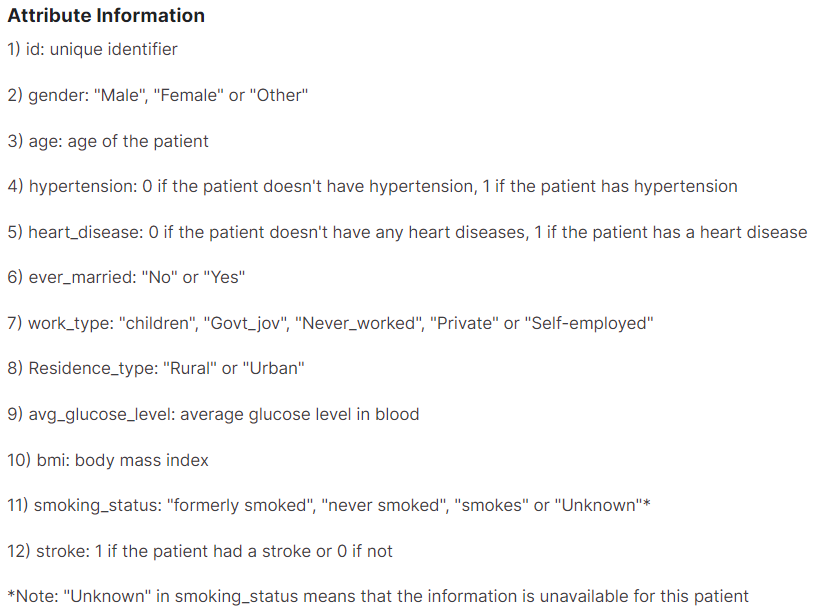

#Data Cleaning
The following topics will be addressed
- Deleted unnecessary columns.
- Deleted duplicate rows.
- Identified and addressed missing values.
- Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- Produced univariate visuals for the target and all features.
- Identified outliers.
- Clearly commented all of your cleaning steps and described any decisions you made.

In [74]:
filename = "/content/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [75]:
#decide to drop id since it doesnt help us make prediction
df = df.drop(["id"], axis=1)

In [76]:
df.duplicated().sum()
#suggest no duplicate

0

In [77]:
df.isna().sum()/len(df)*100
#slight missing values on BMI, can fill it back with simpleimputer later

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [78]:
#check for inconsistent values in categorical columns
for col in list(df.select_dtypes(include='object')):
  print(col)
  print(df[col].value_counts())
  print()
#will drop "other" on gender since its very minor
#Plan to keep "Unknown" in smoking_status because its a huge portion of the col

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [79]:
df[df["gender"] == 'Other']
df.drop(df.loc[df["gender"] == 'Other'].index, inplace=True)
print(df.describe())
df.describe(include="object")

               age  hypertension  heart_disease  avg_glucose_level  \
count  5109.000000   5109.000000    5109.000000        5109.000000   
mean     43.229986      0.097475       0.054022         106.140399   
std      22.613575      0.296633       0.226084          45.285004   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.240000   
50%      45.000000      0.000000       0.000000          91.880000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

              bmi       stroke  
count  4908.00000  5109.000000  
mean     28.89456     0.048738  
std       7.85432     0.215340  
min      10.30000     0.000000  
25%      23.50000     0.000000  
50%      28.10000     0.000000  
75%      33.10000     0.000000  
max      97.60000     1.000000  


,gender,ever_married,work_type,Residence_type,smoking_status
count,5109,5109,5109,5109,5109
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2924,2596,1892


- [From this link](https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test) , glucose level between 70-99 mg/dl is considered normal whilst 100-125 suggests prediabetes. If the blood glucose level is 126 mg/dl (7.0 mmol/L) or higher on more than one testing occasion, it usually means diabetes. Therefore, I do not plan to change anything on "avg_glucose_level".

- max bmi 97 is still in reasonable range when talking abt extreme obesity scenario.


In [80]:
#Feature ranking with recursive feature elimination
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
#class sklearn.feature_selection.RFE(estimator, *, n_features_to_select=None, 
                                    #step=1, verbose=0, importance_getter='auto')

#Exploratory Data

##On each and individual columns

In [81]:
#Strategy
#stroke, hypertension and heart_disease are binary variable -> pie chart
#categorial data -> barplot
#numercial data -> histogram

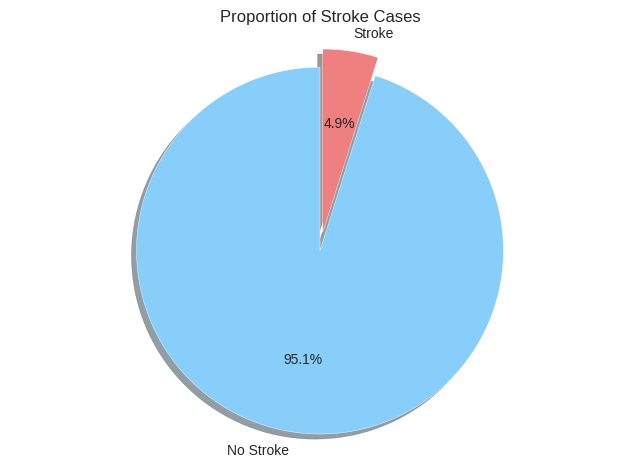

In [82]:
#TARGET!!
stroke_count = df['stroke'].value_counts()
labels = ['No Stroke', 'Stroke']
colors = ['lightskyblue', 'lightcoral']
explode = (0, 0.1)
plt.pie(stroke_count, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Proportion of Stroke Cases')
plt.show()

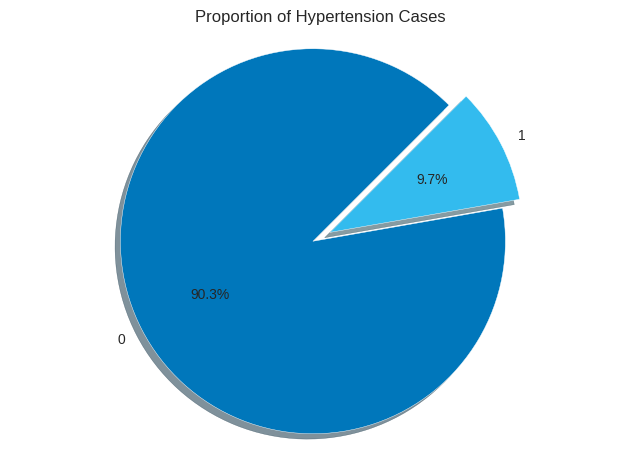

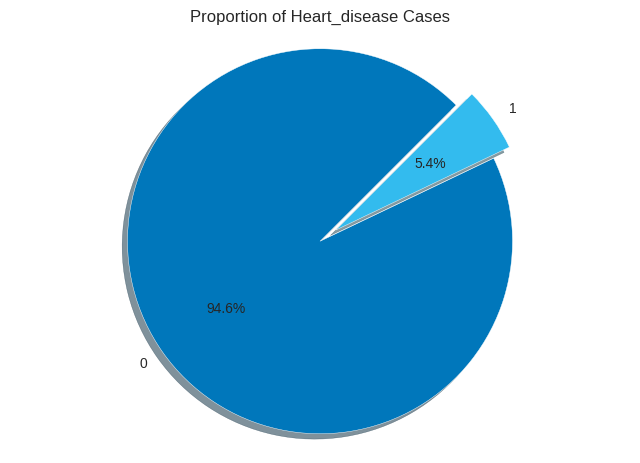

In [83]:
columns = ['hypertension', 'heart_disease']

#create a pie chart for these two columns
for column in columns:
    column_count = df[column].value_counts()
    labels = [str(x) for x in column_count.index]
    colors = ['#0077BB', '#33BBEE']
    explode = (0, 0.1)
    plt.pie(column_count, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=45)
    plt.axis('equal')
    plt.title(f"Proportion of {column.capitalize()} Cases")
    plt.show()

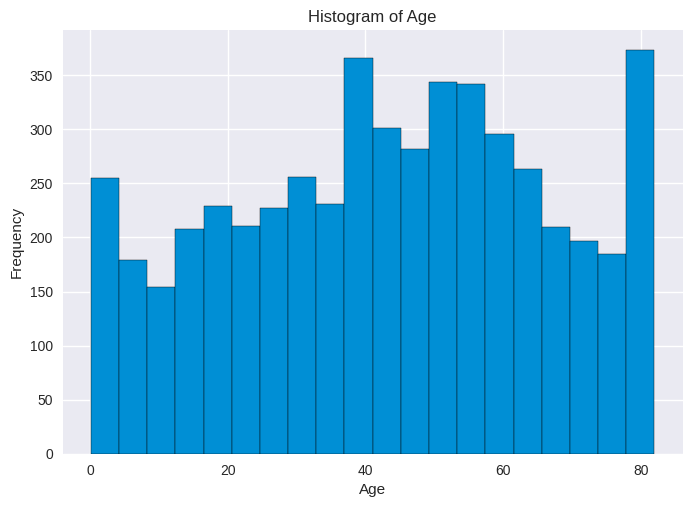

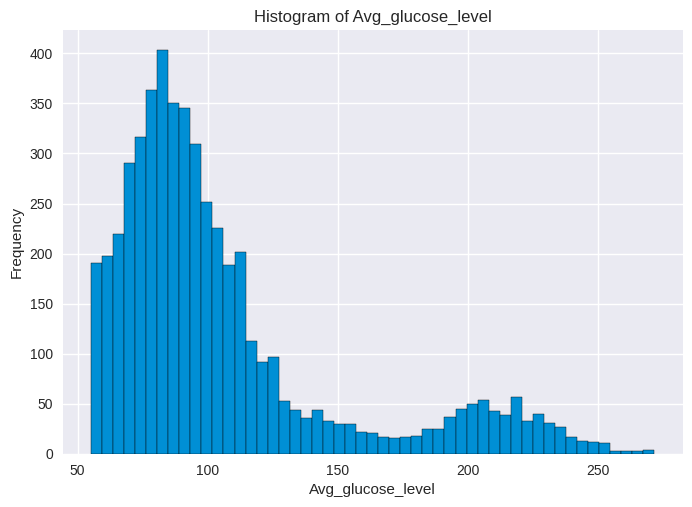

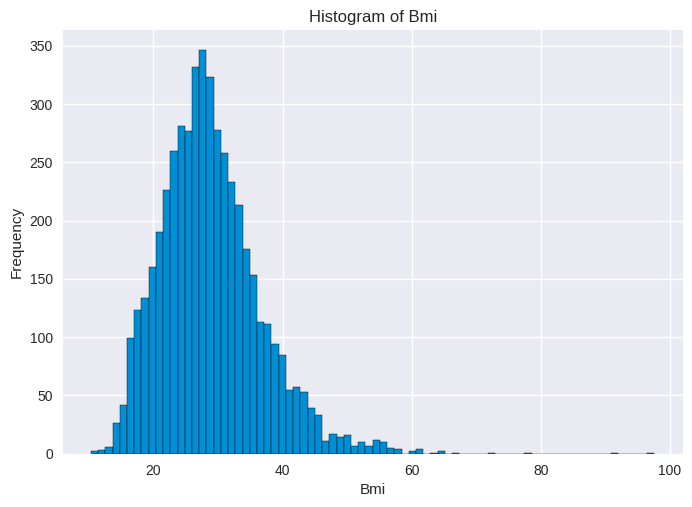

In [84]:
#create histograms for each numerical column
for col in ['age', 'avg_glucose_level', 'bmi']:
    plt.hist(df[col], bins="auto", color='#008fd5', edgecolor="black")
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col.capitalize()}')
    plt.show()

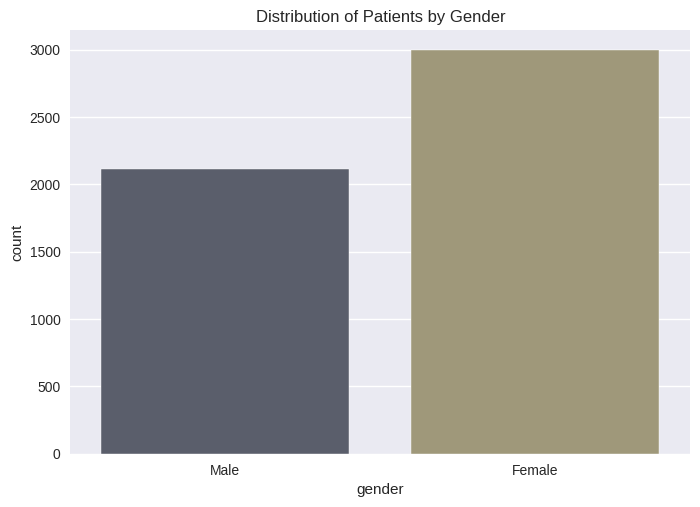

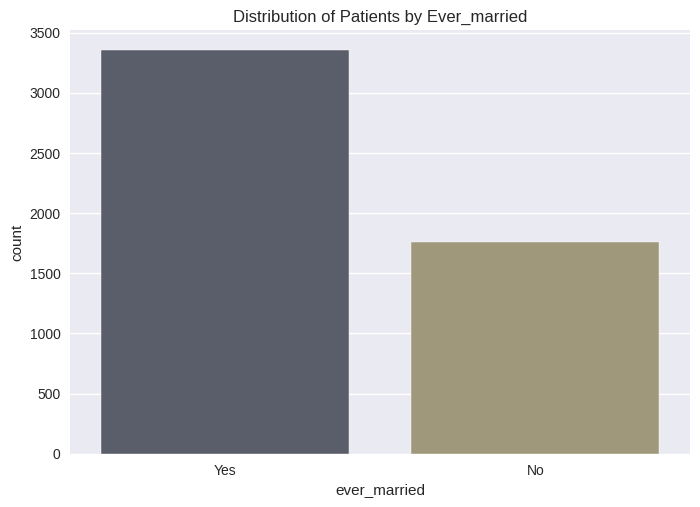

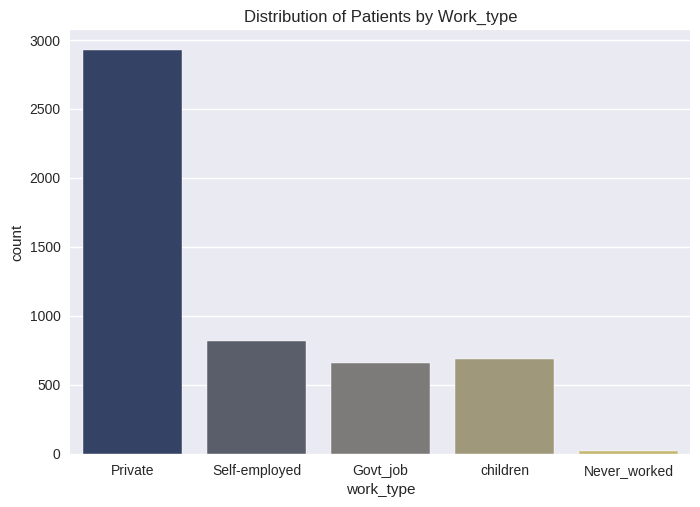

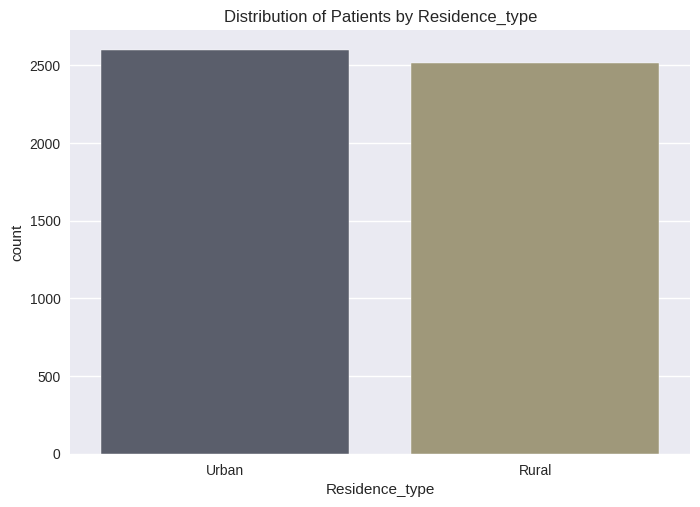

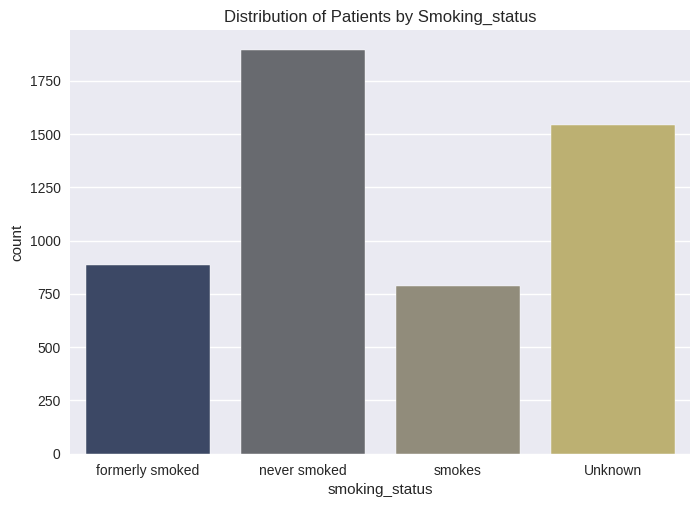

In [85]:
##present every categorial data with countplots
for col in df.select_dtypes(include='object').columns:
    sns.countplot(x=col, data=df, palette='cividis')
    plt.title(f'Distribution of Patients by {col.capitalize()}')
    plt.show()

##Identifying correlations between target and features

In [86]:
#interested to know how smoking status is correlated with stroke
#decide to manually transform categorial col to #
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1})
df['gender'].value_counts()

0    2994
1    2115
Name: gender, dtype: int64

In [87]:
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['ever_married'].value_counts()

1    3353
0    1756
Name: ever_married, dtype: int64

In [88]:
df['work_type'] = df['work_type'].replace({'Never_worked': 0, 'children': 1, 'Govt_job': 2, 'Self-employed': 3, 'Private': 4 })
df['work_type'].value_counts()

4    2924
3     819
1     687
2     657
0      22
Name: work_type, dtype: int64

In [89]:
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1})
df['Residence_type'].value_counts()

0    2596
1    2513
Name: Residence_type, dtype: int64

In [90]:
df['smoking_status'] = df['smoking_status'].replace({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3 })
df['smoking_status'].value_counts()

1    1892
3    1544
0     884
2     789
Name: smoking_status, dtype: int64

<Axes: >

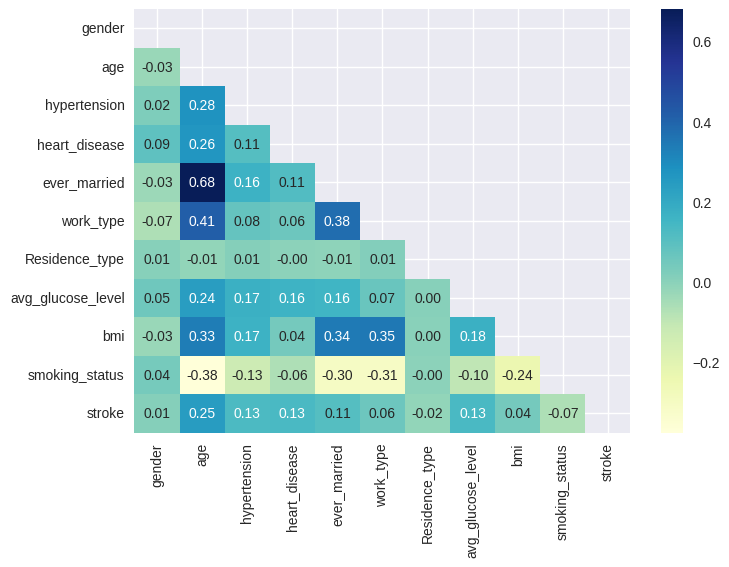

In [91]:
# Correlation Heatmap
corr = df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap = 'YlGnBu', annot = True, fmt=".2f", mask = mask)

other than "age" columns, target "stroke" has very limit correlation with others. Note that age has has significant correlation with most other columns. 

##Creating multivariate visualizations to further understand data

###Scatter Plot

Text(0, 0.5, 'BMI')

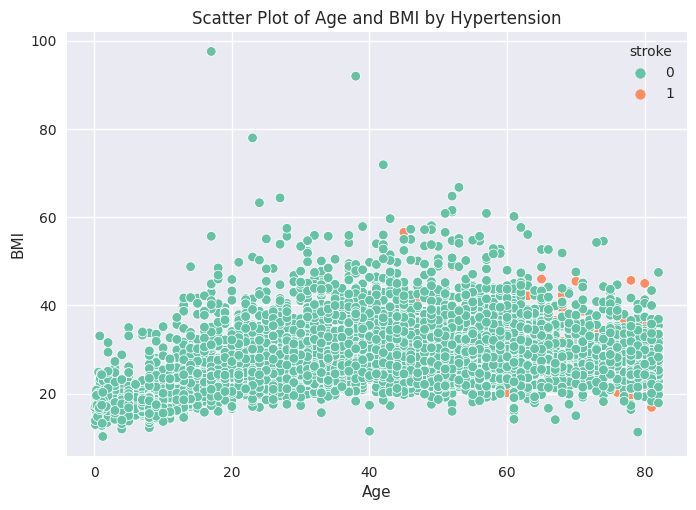

In [92]:
sns.set_style('darkgrid')
sns.scatterplot(y ='bmi', x = 'age', data = df, hue = 'stroke', palette='Set2')
plt.title('Scatter Plot of Age and BMI by Hypertension')
plt.xlabel('Age')
plt.ylabel('BMI')
#Interested to see what its like if i can separate 0 and 1 stroke

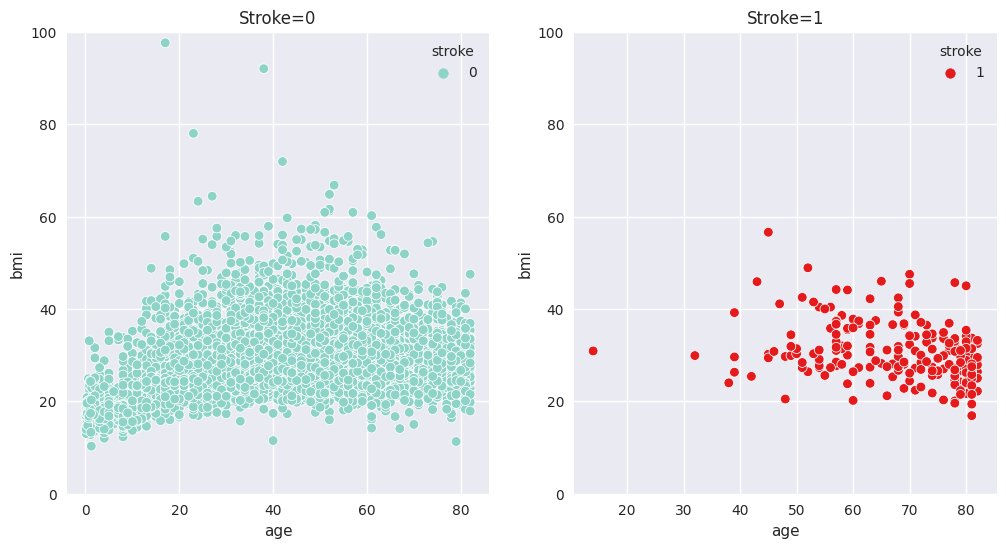

In [93]:
#dataframes for stroke=0 and 1 individually
df_stroke_0 = df[df['stroke'] == 0]
df_stroke_1 = df[df['stroke'] == 1]

#set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

#scatterplot for stroke=0
sns.scatterplot(ax=ax1, x='age', y='bmi', data=df_stroke_0, hue='stroke', palette='Set3')
ax1.set_title('Stroke=0')

#scatterplot for stroke=1
sns.scatterplot(ax=ax2, x='age', y='bmi', data=df_stroke_1, hue='stroke', palette='Set1')
ax2.set_title('Stroke=1')

#set y-limits for both plots to be the same scale
ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)

plt.show()


###Bar Plot

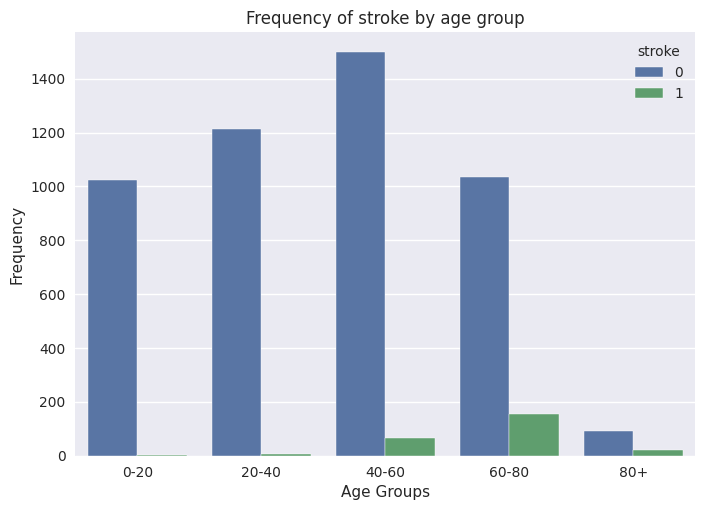

In [94]:
#create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '20-40', '40-60', '60-80', '80+'])

sns.countplot(x='age_group', hue='stroke', data=df)

plt.title('Frequency of stroke by age group')
plt.xlabel('Age Groups')
plt.ylabel('Frequency')

plt.show()

###Line Plot

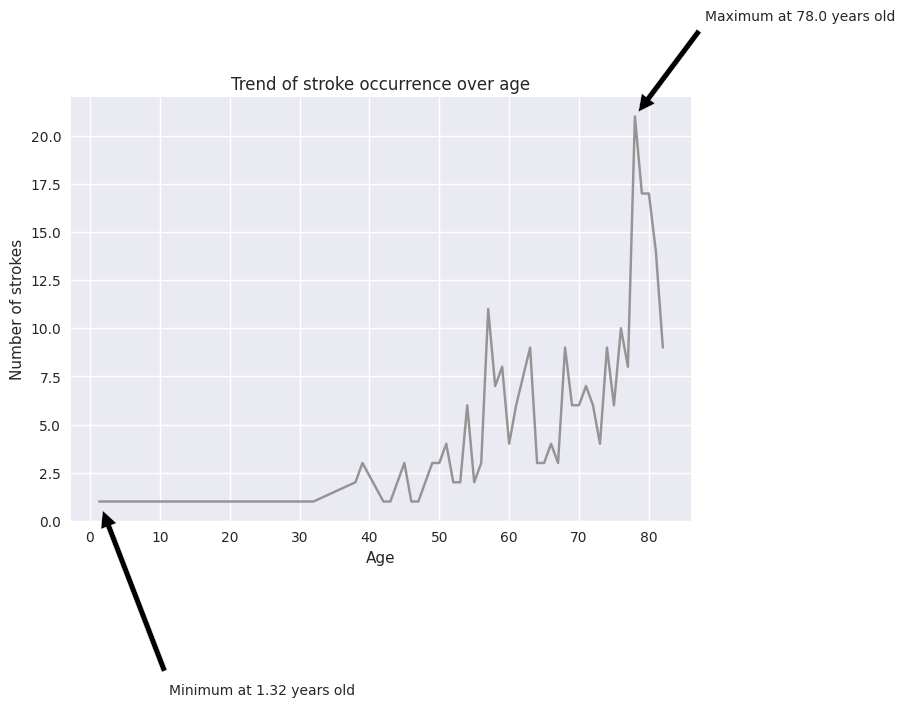

In [95]:
#grouby age and stroke count data
age_stroke_counts = df[df['stroke']==1].groupby(['age'])['stroke'].count().reset_index(name='count')

#plot the line
plt.plot(age_stroke_counts['age'], age_stroke_counts['count'], color=sns.color_palette("colorblind")[7])

#add annotation for the highest count
max_count = age_stroke_counts['count'].max()
max_count_age = age_stroke_counts[age_stroke_counts['count']==max_count]['age'].values[0]
plt.annotate(f'Maximum at {max_count_age} years old', xy=(max_count_age, max_count), xytext=(max_count_age+10, max_count+5), 
             arrowprops=dict(facecolor='black', shrink=0.05))


#get age with the minimum stroke count
min_count = age_stroke_counts['count'].min()
min_count_age = age_stroke_counts[age_stroke_counts['count'] == min_count]['age'].values[0]
plt.annotate(f'Minimum at {min_count_age} years old', xy=(min_count_age, min_count), xytext=(min_count_age+10, min_count-10), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('Age')
plt.ylabel('Number of strokes')
plt.title('Trend of stroke occurrence over age')

plt.show()


##Summary



*   From scatterplots , it is shown that strokes occurs on older population especially after 50 years old.

*   Bar chart above suggest most of the stroke patient are within the age group of 60 to 80 years old.

*   Line plot suggests the trend of stroke occurrence throughout different age. It is observed that there is a spike on mid to late 50s, also found that most of ppl with stroke is on age of 78.









#Supervised Mahcine Learning Models

##Game Plan
This is a classification dataset and below are what I plan to do:

1. Making preprocessor.

2. Finding the best resampling method between oversampling and SMOTE on each machine learning models. The main reason I chooe oversampling and SMOTE is because I would rather to have more data to compare, rather than downsizing an abundant data in which I could lost track of its  

3. Hyptertuning each machine learning models that has the best resampling method.

4. All models are compared with a custom function I wrote for classification problem.

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5109 non-null   int64   
 1   age                5109 non-null   float64 
 2   hypertension       5109 non-null   int64   
 3   heart_disease      5109 non-null   int64   
 4   ever_married       5109 non-null   int64   
 5   work_type          5109 non-null   int64   
 6   Residence_type     5109 non-null   int64   
 7   avg_glucose_level  5109 non-null   float64 
 8   bmi                4908 non-null   float64 
 9   smoking_status     5109 non-null   int64   
 10  stroke             5109 non-null   int64   
 11  age_group          5109 non-null   category
dtypes: category(1), float64(3), int64(8)
memory usage: 484.2 KB


In [97]:
#split data
y = df['stroke']
X = df.drop(columns =['stroke'])
#X = df.drop(columns =['stroke', 'bmi', ])
X.shape

(5109, 11)

In [98]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#check balance of target data
print(y.value_counts(normalize= True))
print('\n')
y.value_counts()
#results shows an inbalanced data where most are 0s
#baseline for 0 and 1 = 95.1% and 4.9%

0    0.951262
1    0.048738
Name: stroke, dtype: float64




0    4860
1     249
Name: stroke, dtype: int64

##Completing the appropriate pre-processing steps

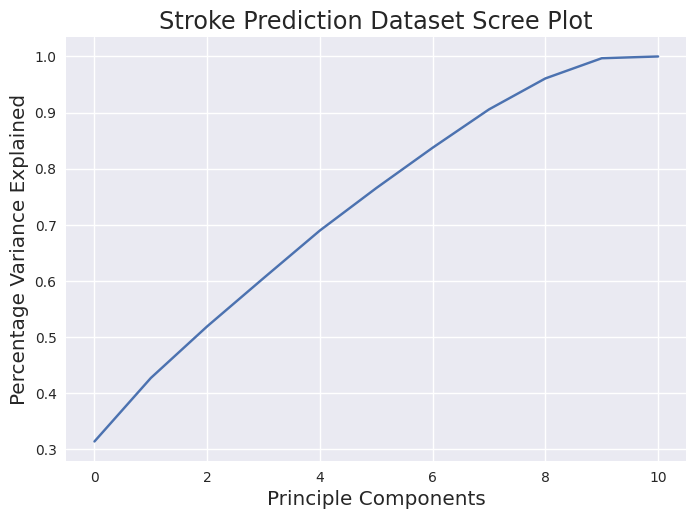

In [99]:
pca = PCA()
#on numeric
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean')
num_pipeline = make_pipeline(mean_imputer, scaler)
num_selector = make_column_selector(dtype_include="number")
num_tuple = (num_pipeline, num_selector)

#on ordinal
ord = OrdinalEncoder()
ord_pipeline = make_pipeline(ord, scaler)
ord_selector = make_column_selector(dtype_include="category")
ord_tuple = (ord_pipeline, ord_selector)

# Instantiate the make column transformer
preprocessor = make_column_transformer(num_tuple, ord_tuple, remainder="drop", verbose_feature_names_out=False)
# Fit to X train
preprocessor.fit(X_train)
# Use PCA to determine the optimal number of components
pca.fit_transform(preprocessor.transform(X_train))
# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Stroke Prediction Dataset Scree Plot", fontsize="xx-large")
plt.show()

In [100]:
#decide to select PCA with 7 components, we will only use 63% (7/11) of features 
#but still receive 90% effect
pca7 = PCA(n_components=7)

##Ideitifying Resampling methods work best for Machine Learning Models 

In [101]:
# create dataframe to save model evaluation scores in
class_metrics_df = pd.DataFrame(columns = ['Train Accuracy', 'Test Accuracy', 'Train Recall (Sensitivity)', 'Test Recall (Sensitivity)', 'Train Precision', 'Test Precision', 'Train Specificity', 'Test Specificity', 'Train F1', 'Test F1', 'Train AUPRC', 'Test AUPRC'])
class_metrics_df.copy()
class_metrics_df

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC


In [102]:
def classification_metrics(model_pipe, X_train, X_test, y_train, y_test, name):
    y_train_pred = model_pipe.predict(X_train)
    class_metrics_df.at[name, 'Train Accuracy'] = round(accuracy_score(y_train, y_train_pred), 3)
    class_metrics_df.at[name, 'Train Recall (Sensitivity)'] = round(recall_score(y_train, y_train_pred), 3)
    class_metrics_df.at[name, 'Train Precision'] = round(precision_score(y_train, y_train_pred), 3)
    class_metrics_df.at[name, 'Train F1'] = round(f1_score(y_train, y_train_pred), 3)
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    train_specificity = tn / (tn + fp)
    class_metrics_df.at[name, 'Train Specificity'] = round(train_specificity, 3)
    # Calculate AUPRC for training set
    precision, recall, _ = precision_recall_curve(y_train, y_train_pred)
    train_auprc = auc(recall, precision)
    class_metrics_df.at[name, 'Train AUPRC'] = round(train_auprc, 3)
    class_metrics_df.at[name, 'Train TP'] = round(tp / sum(y_train), 3) # normalized TP
    
    y_test_pred = model_pipe.predict(X_test)
    class_metrics_df.at[name, 'Test Accuracy'] = round(accuracy_score(y_test, y_test_pred), 3)
    class_metrics_df.at[name, 'Test Recall (Sensitivity)'] = round(recall_score(y_test, y_test_pred), 3)
    class_metrics_df.at[name, 'Test Precision'] = round(precision_score(y_test, y_test_pred), 3)
    class_metrics_df.at[name, 'Test F1'] = round(f1_score(y_test, y_test_pred), 3)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    test_specificity = tn / (tn + fp)
    class_metrics_df.at[name, 'Test Specificity'] = round(test_specificity, 3)
    # Calculate AUPRC for test set
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    test_auprc = auc(recall, precision)
    class_metrics_df.at[name, 'Test AUPRC'] = round(test_auprc, 3)
    class_metrics_df.at[name, 'Test TP'] = round(tp / sum(y_test), 3) # normalized TP


###Logostic Regression

In [103]:
#default logreg
logreg = LogisticRegression()
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit logreg_pipe.fit(X_train, y_train)

28.5 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


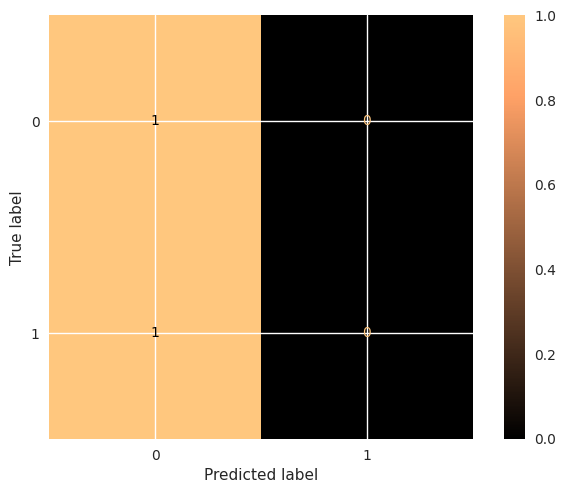

In [104]:
logreg_predictions = logreg_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, logreg_predictions, display_labels=labels, cmap="copper", normalize="true")

In [105]:
#pca logreg
pca_logreg = LogisticRegression()
pca_logreg_pipe = make_pipeline(preprocessor, pca7, pca_logreg)
pca_logreg_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit logreg_pipe.fit(X_train, y_train)

25.9 ms ± 794 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


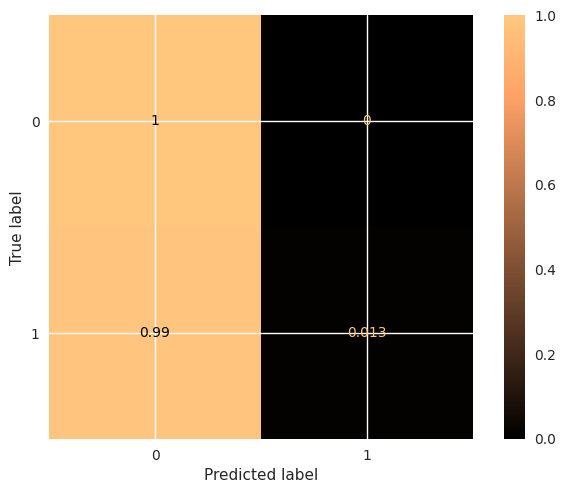

In [106]:
pca_logreg_predictions = pca_logreg_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pca_logreg_predictions, display_labels=labels, cmap="copper", normalize="true")

In [107]:
#oversampling logreg
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
log_reg_over = LogisticRegression()
over_sample_log_reg_pipe = make_sampler_pipeline(preprocessor, over_sampler, log_reg_over)
#Fit and evaluate the model
over_sample_log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff224386650>)],
                                   verbose_feature_names_out=False)),
                ('randomoversampler', RandomOverSampler()),
                ('logisticregression', LogisticRegression())])

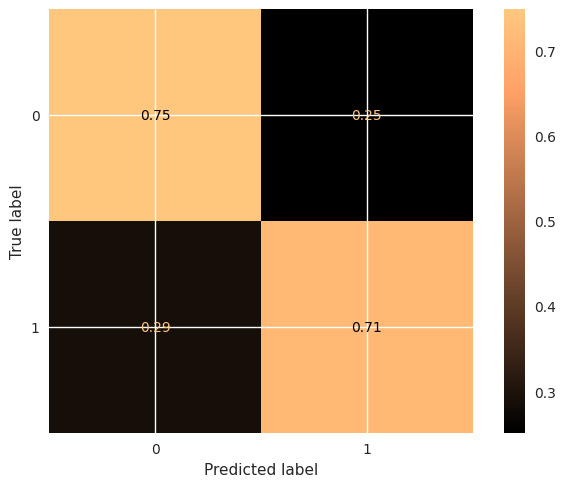

In [108]:
over_sample_log_reg_predictions = over_sample_log_reg_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_log_reg_predictions, display_labels=labels, cmap="copper", normalize="true")

In [109]:
#SMOTE logreg
smote = SMOTE()
log_reg_smote = LogisticRegression()
log_reg_smote_pipe = make_sampler_pipeline(preprocessor, smote, log_reg_smote)
#Fit and evaluate the model pipeline
log_reg_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff224386650>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression())])

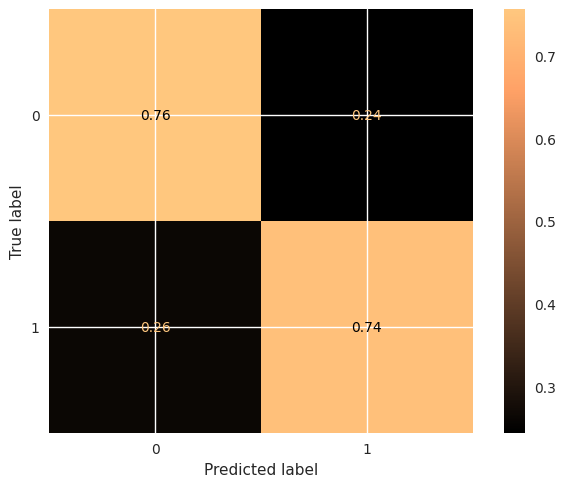

In [110]:
log_reg_smote_predictions = log_reg_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, log_reg_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [111]:
classification_metrics(logreg_pipe, X_train, X_test, y_train, y_test, "Logistic Regresion")
classification_metrics(pca_logreg_pipe, X_train, X_test, y_train, y_test, "PCA Logistic Regresion")
classification_metrics(over_sample_log_reg_pipe, X_train, X_test, y_train, y_test, "Oversampling Tuned Logistic Regresion")
classification_metrics(log_reg_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE Logistic Regresion")
class_metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.938,0.006,0.012,1.0,1.0,1.0,1.0,0.012,0.025,0.525,0.537,0.006,0.012
Oversampling Tuned Logistic Regresion,0.755,0.746,0.828,0.712,0.133,0.159,0.752,0.749,0.23,0.26,0.485,0.445,0.828,0.712
SMOTE Logistic Regresion,0.762,0.755,0.811,0.738,0.135,0.168,0.76,0.756,0.231,0.274,0.477,0.461,0.811,0.738


###Random Forest

In [112]:
#default rf
rf = RandomForestClassifier()
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit rf_pipe.fit(X_train, y_train)

393 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


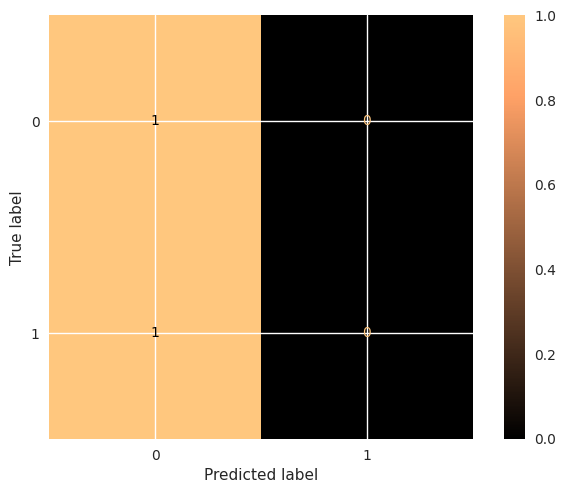

In [113]:
rf_predictions = rf_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, rf_predictions, display_labels=labels, cmap="copper", normalize="true")

In [114]:
#pca rf
pca_rf = RandomForestClassifier()
pca_rf_pipe = make_pipeline(preprocessor, pca7, pca_rf)
pca_rf_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_rf_pipe.fit(X_train, y_train)

1.05 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [115]:
#oversampling rf
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
rf_over = RandomForestClassifier()
over_sample_rf_pipe = make_sampler_pipeline(preprocessor, over_sampler, rf_over)
#Fit and evaluate the model
over_sample_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff224386650>)],
                                   verbose_feature_names_out=False)),
                ('randomoversampler', RandomOverSampler()),
                ('randomforestclassifier', RandomForestClassifier())])

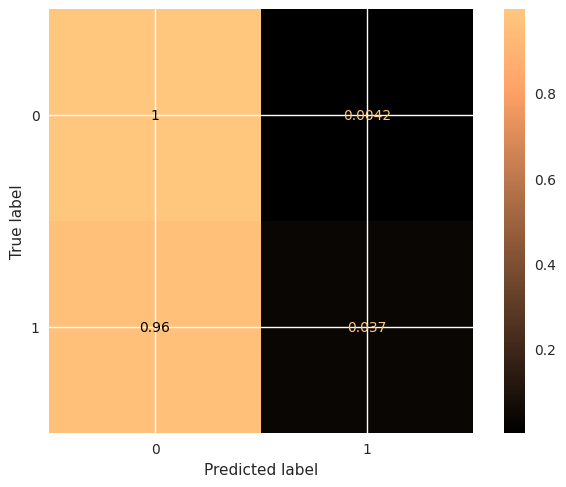

In [116]:
over_sample_rf_predictions = over_sample_rf_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_rf_predictions, display_labels=labels, cmap="copper", normalize="true")

In [117]:
#SMOTE rf
smote = SMOTE()
rf_smote = RandomForestClassifier()
rf_smote_pipe = make_sampler_pipeline(preprocessor, smote, rf_smote)
#Fit and evaluate the model pipeline
rf_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff224386650>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

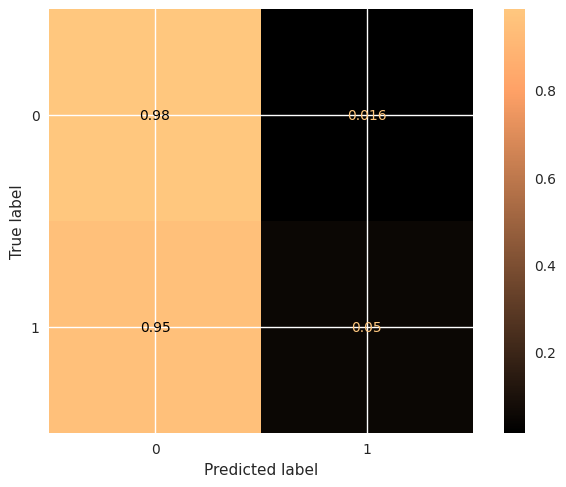

In [118]:
rf_smote_predictions = rf_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, rf_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [119]:
classification_metrics(rf_pipe, X_train, X_test, y_train, y_test, "Random Forest")
classification_metrics(pca_rf_pipe, X_train, X_test, y_train, y_test, "PCA Random Forest")
classification_metrics(over_sample_rf_pipe, X_train, X_test, y_train, y_test, "Oversampling Tuned Random Forest")
classification_metrics(rf_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE Random Forest")
class_metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.938,0.006,0.012,1.0,1.0,1.0,1.0,0.012,0.025,0.525,0.537,0.006,0.012
Oversampling Tuned Logistic Regresion,0.755,0.746,0.828,0.712,0.133,0.159,0.752,0.749,0.23,0.26,0.485,0.445,0.828,0.712
SMOTE Logistic Regresion,0.762,0.755,0.811,0.738,0.135,0.168,0.76,0.756,0.231,0.274,0.477,0.461,0.811,0.738
Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.531,1.000,0.000
PCA Random Forest,1.0,0.938,0.994,0.012,1.0,1.0,1.0,1.0,0.997,0.025,0.997,0.537,0.994,0.012
Oversampling Tuned Random Forest,1.0,0.936,1.0,0.038,1.0,0.375,1.0,0.996,1.0,0.068,1.0,0.236,1.000,0.038
SMOTE Random Forest,1.0,0.926,1.0,0.05,1.0,0.174,1.0,0.984,1.0,0.078,1.0,0.142,1.000,0.050


###KNN

In [120]:
#default KNN
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit knn_pipe.fit(X_train, y_train)

15.9 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


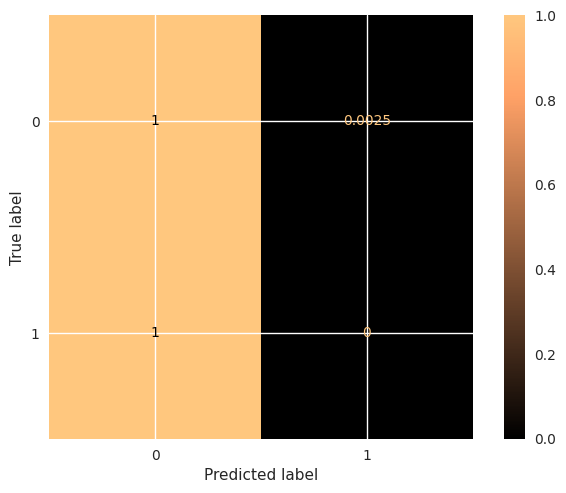

In [121]:
knn_predictions = knn_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_predictions, display_labels=labels, cmap="copper", normalize="true")

In [122]:
#pca knn
pca_knn = KNeighborsClassifier()
pca_knn_pipe = make_pipeline(preprocessor, pca7, pca_knn)
pca_knn_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_knn_pipe.fit(X_train, y_train)

37.4 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


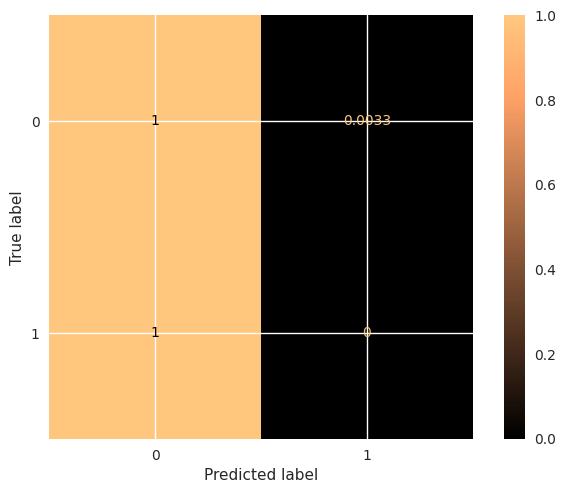

In [123]:
pca_knn_predictions = pca_knn_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pca_knn_predictions, display_labels=labels, cmap="copper", normalize="true")

In [124]:
#oversampling knn
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
knn_over = KNeighborsClassifier()
over_sample_knn_pipe = make_sampler_pipeline(preprocessor, over_sampler, knn_over)
#Fit and evaluate the model
over_sample_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff224386650>)],
                                   verbose_feature_names_out=False)),
                ('randomoversampler', RandomOverSampler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

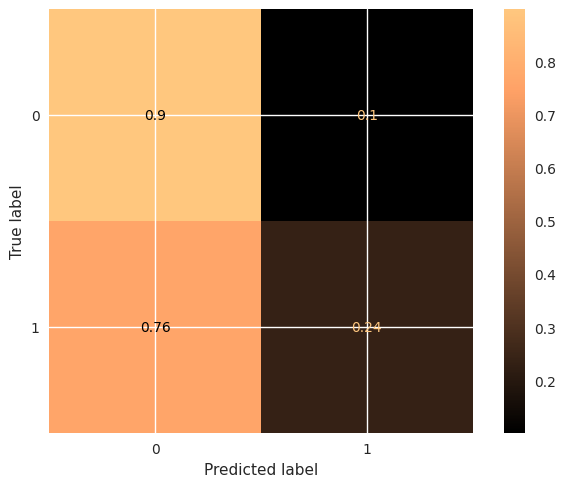

In [125]:
over_sample_knn_predictions = over_sample_knn_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_knn_predictions, display_labels=labels, cmap="copper", normalize="true")

In [126]:
#SMOTE KNN
smote = SMOTE()
knn_smote = KNeighborsClassifier()
knn_smote_pipe = make_sampler_pipeline(preprocessor, smote, knn_smote)
#Fit and evaluate the model pipeline
knn_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff224386650>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('kneighborsclassifier', KNeighborsClassifier())])

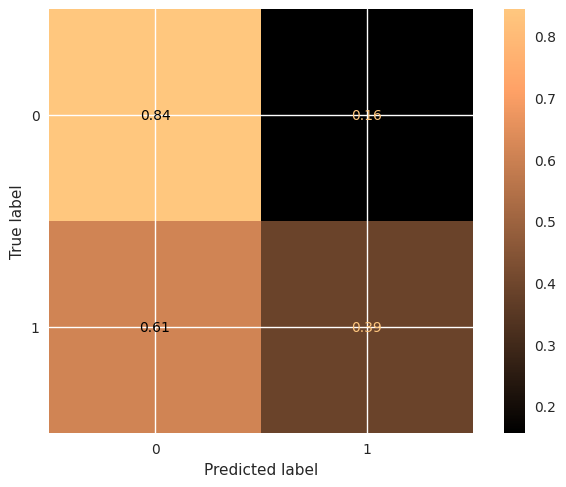

In [127]:
knn_smote_predictions = knn_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [128]:
classification_metrics(knn_pipe, X_train, X_test, y_train, y_test, "KNN")
classification_metrics(pca_knn_pipe, X_train, X_test, y_train, y_test, "PCA KNN")
classification_metrics(over_sample_knn_pipe, X_train, X_test, y_train, y_test, "Oversampling KNN")
classification_metrics(knn_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE KNN")
class_metrics_df

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.938,0.006,0.012,1.0,1.0,1.0,1.0,0.012,0.025,0.525,0.537,0.006,0.012
Oversampling Tuned Logistic Regresion,0.755,0.746,0.828,0.712,0.133,0.159,0.752,0.749,0.23,0.26,0.485,0.445,0.828,0.712
SMOTE Logistic Regresion,0.762,0.755,0.811,0.738,0.135,0.168,0.76,0.756,0.231,0.274,0.477,0.461,0.811,0.738
Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.531,1.000,0.000
PCA Random Forest,1.0,0.938,0.994,0.012,1.0,1.0,1.0,1.0,0.997,0.025,0.997,0.537,0.994,0.012
Oversampling Tuned Random Forest,1.0,0.936,1.0,0.038,1.0,0.375,1.0,0.996,1.0,0.068,1.0,0.236,1.000,0.038
SMOTE Random Forest,1.0,0.926,1.0,0.05,1.0,0.174,1.0,0.984,1.0,0.078,1.0,0.142,1.000,0.050
KNN,0.958,0.935,0.059,0.0,0.769,0.0,0.999,0.997,0.11,0.0,0.435,0.031,0.059,0.000
PCA KNN,0.957,0.934,0.041,0.0,0.875,0.0,1.0,0.997,0.079,0.0,0.479,0.031,0.041,0.000


###XGBooster

In [129]:
#XGBooster
xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

# Measure how long it takes to train without PCA
%timeit xgb_pipe.fit(X_train, y_train)

The slowest run took 6.65 times longer than the fastest. This could mean that an intermediate result is being cached.
641 ms ± 674 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


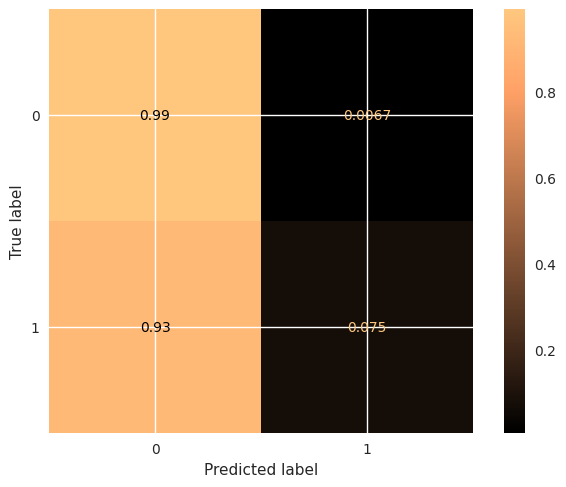

In [130]:
xgb_predictions = xgb_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, xgb_predictions, display_labels=labels, cmap="copper", normalize="true")

In [131]:
#pca XGBooster
pca_xgb = XGBClassifier()
pca_xgb_pipe = make_pipeline(preprocessor, pca7, pca_xgb)
pca_xgb_pipe.fit(X_train, y_train)

# Measure how long it takes to train with PCA
%timeit pca_xgb_pipe.fit(X_train, y_train)

723 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


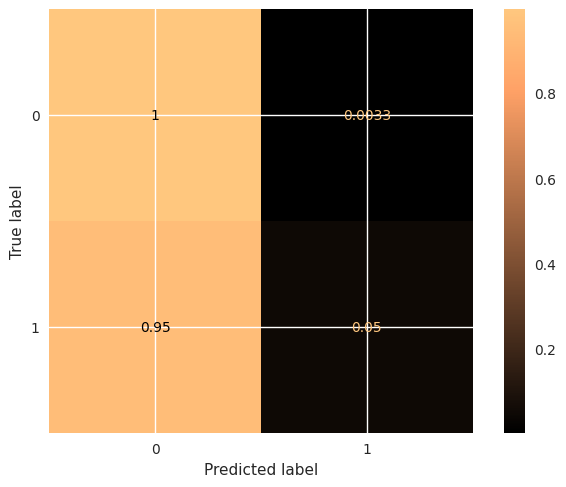

In [132]:
pca_xgb_predictions = pca_xgb_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pca_xgb_predictions, display_labels=labels, cmap="copper", normalize="true")

In [133]:
#oversampling XGBooster
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(preprocessor, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
xgb_over = XGBClassifier()
over_sample_xgb_pipe = make_sampler_pipeline(preprocessor, over_sampler, xgb_over)
#Fit and evaluate the model
over_sample_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScale...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

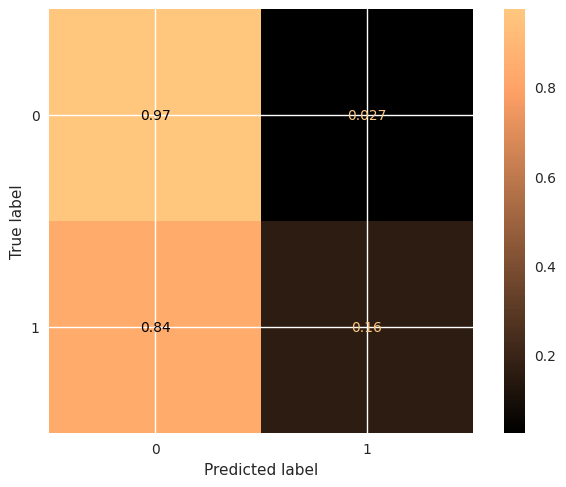

In [134]:
over_sample_xgb_predictions = over_sample_xgb_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, over_sample_xgb_predictions, display_labels=labels, cmap="copper", normalize="true")

In [135]:
#SMOTE XGBooster
smote = SMOTE()
xgb_smote = XGBClassifier()
xgb_smote_pipe = make_sampler_pipeline(preprocessor, smote, xgb_smote)
#Fit and evaluate the model pipeline
xgb_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff2243874c0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScale...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

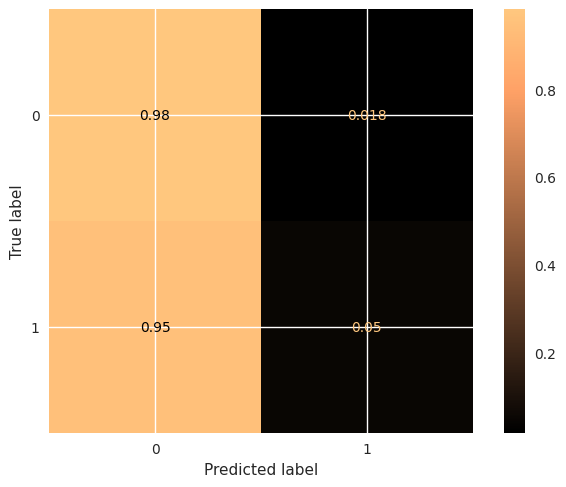

In [136]:
xgb_smote_predictions = xgb_smote_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, xgb_smote_predictions, display_labels=labels, cmap="copper", normalize="true")

In [137]:
classification_metrics(xgb_pipe, X_train, X_test, y_train, y_test, "XGB")
classification_metrics(pca_xgb_pipe, X_train, X_test, y_train, y_test, "PCA XGB")
classification_metrics(over_sample_xgb_pipe, X_train, X_test, y_train, y_test, "Oversampling XGB")
classification_metrics(xgb_smote_pipe, X_train, X_test, y_train, y_test, "SMOTE XGB")
class_metrics_df

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.938,0.006,0.012,1.0,1.0,1.0,1.0,0.012,0.025,0.525,0.537,0.006,0.012
Oversampling Tuned Logistic Regresion,0.755,0.746,0.828,0.712,0.133,0.159,0.752,0.749,0.23,0.26,0.485,0.445,0.828,0.712
SMOTE Logistic Regresion,0.762,0.755,0.811,0.738,0.135,0.168,0.76,0.756,0.231,0.274,0.477,0.461,0.811,0.738
Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.531,1.000,0.000
PCA Random Forest,1.0,0.938,0.994,0.012,1.0,1.0,1.0,1.0,0.997,0.025,0.997,0.537,0.994,0.012
Oversampling Tuned Random Forest,1.0,0.936,1.0,0.038,1.0,0.375,1.0,0.996,1.0,0.068,1.0,0.236,1.000,0.038
SMOTE Random Forest,1.0,0.926,1.0,0.05,1.0,0.174,1.0,0.984,1.0,0.078,1.0,0.142,1.000,0.050
KNN,0.958,0.935,0.059,0.0,0.769,0.0,0.999,0.997,0.11,0.0,0.435,0.031,0.059,0.000
PCA KNN,0.957,0.934,0.041,0.0,0.875,0.0,1.0,0.997,0.079,0.0,0.479,0.031,0.041,0.000


###Result

In [138]:
class_metrics_df.sort_values('Test TP', ascending=False)

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
SMOTE Logistic Regresion,0.762,0.755,0.811,0.738,0.135,0.168,0.76,0.756,0.231,0.274,0.477,0.461,0.811,0.738
Oversampling Tuned Logistic Regresion,0.755,0.746,0.828,0.712,0.133,0.159,0.752,0.749,0.23,0.26,0.485,0.445,0.828,0.712
SMOTE KNN,0.881,0.815,1.0,0.388,0.27,0.142,0.875,0.843,0.426,0.207,0.635,0.284,1.000,0.388
Oversampling KNN,0.923,0.857,1.0,0.238,0.365,0.135,0.92,0.898,0.535,0.172,0.683,0.21,1.000,0.238
Oversampling XGB,0.999,0.923,1.0,0.162,0.988,0.289,0.999,0.973,0.994,0.208,0.994,0.252,1.000,0.162
XGB,0.999,0.936,0.988,0.075,1.0,0.429,1.0,0.993,0.994,0.128,0.994,0.281,0.988,0.075
SMOTE Random Forest,1.0,0.926,1.0,0.05,1.0,0.174,1.0,0.984,1.0,0.078,1.0,0.142,1.000,0.050
PCA XGB,1.0,0.937,1.0,0.05,1.0,0.5,1.0,0.997,1.0,0.091,1.0,0.305,1.000,0.050
SMOTE XGB,0.998,0.924,0.959,0.05,0.994,0.16,1.0,0.982,0.976,0.076,0.977,0.135,0.959,0.050
Oversampling Tuned Random Forest,1.0,0.936,1.0,0.038,1.0,0.375,1.0,0.996,1.0,0.068,1.0,0.236,1.000,0.038


We want a model that can best predict true positive, especially on a imbalanced data like this, as much as possible. Therefore, I would emphasize on the column of Test TP. 

Since the resample logistic regresion model can predict more than 70% on true positives, so I am interested to know if I can tune to make it higher. Moreover, I will also tune SMOTE KNN and see if there is a chance we can reinforce it to over 50%. Finally, Oversampling XGB tuning will be presented for comparison purposes

##Hypertuning each model

###SMOTE logistic regression

In [68]:
#tuned SMOTE logreg
smote = SMOTE()
tuned_log_reg_smote = LogisticRegression(solver='liblinear')
tuned_log_reg_smote_pipe = make_sampler_pipeline(preprocessor, smote, tuned_log_reg_smote)
#start tuning with GS
log_params = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
              'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
tuned_log_reg_smote_gs = GridSearchCV(tuned_log_reg_smote_pipe, log_params)
tuned_log_reg_smote_gs.fit(X_train, y_train)

#get best params
print(tuned_log_reg_smote_gs.best_params_)

# instantiate tuned model
best_tuned_log_reg_smote_pipe = tuned_log_reg_smote_gs.best_estimator_

{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1'}


###SMOTE KNN

In [69]:
#tuned SMOTE KNN
smote = SMOTE()
tuned_knn_smote = KNeighborsClassifier()
tuned_knn_smote_pipe = make_sampler_pipeline(preprocessor, smote, tuned_knn_smote)
#start tuning with GS
knn_params = {'kneighborsclassifier__n_neighbors' : [5,7,9,11,13,15],
          'kneighborsclassifier__weights' : ['uniform','distance'],
          'kneighborsclassifier__metric' : ['minkowski','euclidean','manhattan']}
tuned_knn_smote_gs = GridSearchCV(tuned_knn_smote_pipe, knn_params)
tuned_knn_smote_gs.fit(X_train, y_train)

#get best params
print(tuned_knn_smote_gs.best_params_)

# instantiate tuned model
best_tuned_knn_smote_pipe = tuned_knn_smote_gs.best_estimator_

{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}


###XGBooster

In [70]:
#tuned XGBooster
tuned_xgb = XGBClassifier()
tuned_xgb_pipe = make_pipeline(preprocessor, tuned_xgb)
#start tuning with GS
xgb_params = {'xgbclassifier__learning_rate' : [0.01,0.1,1, 10],
              'xgbclassifier__n_estimators': [1, 10, 15, 20, 25, 30],
          'xgbclassifier__max_depth': [1, 10]}
tuned_xgb_gs = GridSearchCV(tuned_xgb_pipe, xgb_params)
tuned_xgb_gs.fit(X_train, y_train)

#get best params
print(tuned_xgb_gs.best_params_)

# instantiate tuned model
best_tuned_xgb_pipe = tuned_xgb_gs.best_estimator_

{'xgbclassifier__learning_rate': 0.001, 'xgbclassifier__subsample': 0.25}


##Conclusion

In [71]:
classification_metrics(best_tuned_log_reg_smote_pipe, X_train, X_test, y_train, y_test, "Tuned SMOTE Logistic Regresion")
classification_metrics(best_tuned_knn_smote_pipe, X_train, X_test, y_train, y_test, "Tuned SMOTE KNN")
classification_metrics(best_tuned_xgb_pipe, X_train, X_test, y_train, y_test, "Tuned XGB")
class_metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Logistic Regresion,0.956,0.938,0.006,0.012,1.0,1.0,1.0,1.0,0.012,0.025,0.525,0.537,0.006,0.012
Oversampling Tuned Logistic Regresion,0.751,0.74,0.84,0.738,0.133,0.159,0.747,0.74,0.229,0.262,0.49,0.457,0.840,0.738
SMOTE Logistic Regresion,0.764,0.76,0.805,0.725,0.135,0.169,0.762,0.762,0.231,0.274,0.474,0.456,0.805,0.725
Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,0.999,1.0,0.0,1.0,0.031,1.000,0.000
PCA Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.531,1.000,0.000
Oversampling Tuned Random Forest,1.0,0.932,1.0,0.012,1.0,0.111,1.0,0.993,1.0,0.022,1.0,0.093,1.000,0.012
SMOTE Random Forest,1.0,0.923,1.0,0.038,1.0,0.125,1.0,0.982,1.0,0.058,1.0,0.111,1.000,0.038
KNN,0.958,0.935,0.059,0.0,0.769,0.0,0.999,0.997,0.11,0.0,0.435,0.031,0.059,0.000
PCA KNN,0.957,0.934,0.041,0.0,0.875,0.0,1.0,0.997,0.079,0.0,0.479,0.031,0.041,0.000


#Analysis and Recommendations

- On this dataset, the goal is to not only avoid type II error as much as possible but also have as many true positives as many as we can predict.

- Through the analysis above, 

<ipython-input-72-c3a836a0ad6d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


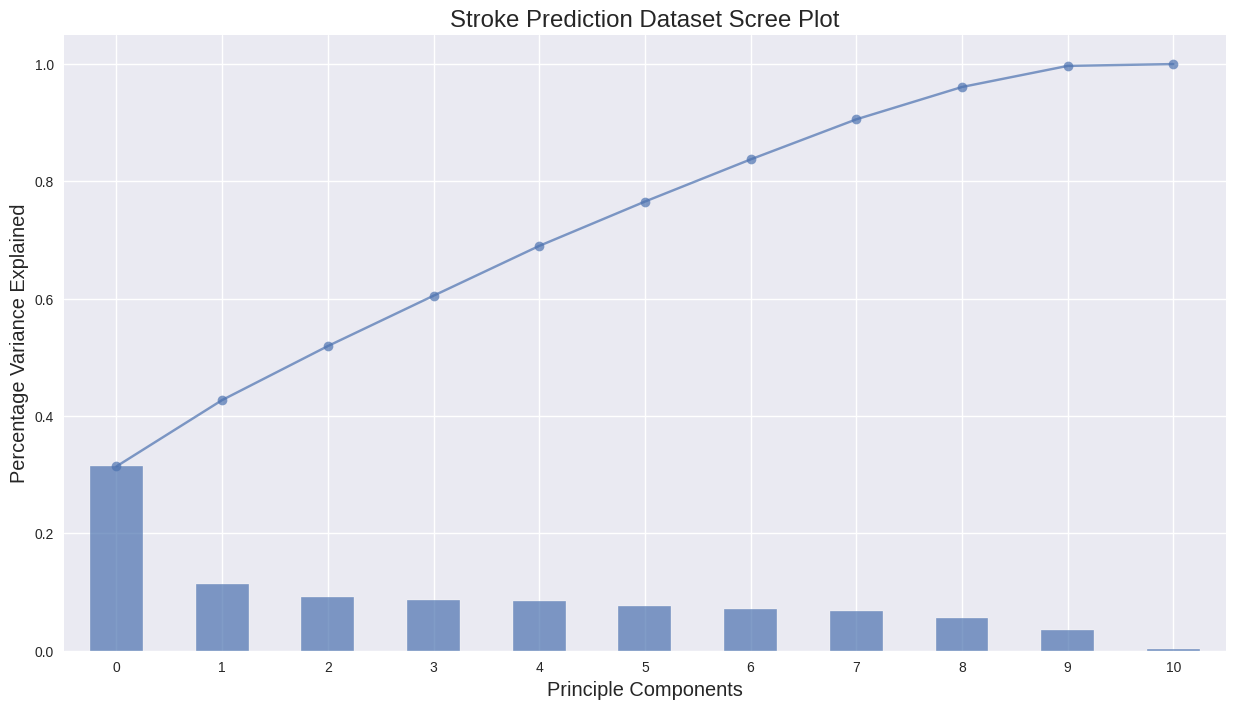

In [72]:
# Lets visual the cummulative sum of the variances 

plt.style.use("seaborn")
plt.figure(figsize=(15,8))
exp_var = pd.Series(pca.explained_variance_ratio_)

# Plot the variance for each component
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)
    
# Plot line chart of increasing variances
pd.Series(var_ls).plot(marker="o", alpha=0.7) 

# Plot labels and titles
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Stroke Prediction Dataset Scree Plot", fontsize="xx-large")
plt.show();

In [67]:
class_metrics_df.sort_values('Test AUPRC', ascending=False)

,Train Accuracy,Test Accuracy,Train Recall (Sensitivity),Test Recall (Sensitivity),Train Precision,Test Precision,Train Specificity,Test Specificity,Train F1,Test F1,Train AUPRC,Test AUPRC,Train TP,Test TP
PCA Logistic Regresion,0.956,0.938,0.006,0.012,1.0,1.0,1.0,1.0,0.012,0.025,0.525,0.537,0.006,0.012
Logistic Regresion,0.956,0.937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.522,0.531,0.000,0.000
PCA Random Forest,1.0,0.937,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.531,1.000,0.000
Oversampling Tuned Logistic Regresion,0.751,0.74,0.84,0.738,0.133,0.159,0.747,0.74,0.229,0.262,0.49,0.457,0.840,0.738
SMOTE Logistic Regresion,0.764,0.76,0.805,0.725,0.135,0.169,0.762,0.762,0.231,0.274,0.474,0.456,0.805,0.725
PCA XGB,1.0,0.937,1.0,0.05,1.0,0.5,1.0,0.997,1.0,0.091,1.0,0.305,1.000,0.050
XGB,0.999,0.936,0.988,0.075,1.0,0.429,1.0,0.993,0.994,0.128,0.994,0.281,0.988,0.075
SMOTE KNN,0.885,0.806,1.0,0.35,0.278,0.125,0.88,0.836,0.434,0.184,0.639,0.258,1.000,0.350
Oversampling XGB,0.999,0.922,1.0,0.15,0.988,0.273,0.999,0.973,0.994,0.194,0.994,0.238,1.000,0.150
Oversampling KNN,0.923,0.857,1.0,0.238,0.365,0.135,0.92,0.898,0.535,0.172,0.683,0.21,1.000,0.238


To decide the best resampling method for each model, I will use AUPRC to evaluate for the following reasons. 

1. since it is a imbalance data, F1 score and AUPRC are both taking into consideration.

2. In my opinion on this data, the cost of false negatives is higher than false positives. For instance, it is more important to correctly predict someone who will have a stroke than to incorrectly predict someone who will not. 

3. In other words, I am fine with enduring false positive. In fact, AUPRC not only makes a great balance between recall and precision but also considers as many positives as possible than other metrics.

From the result of test AUPRC, SMOTE logistic regression, SMOTE KNN and XGBooster each has the best performance among each model.